In [ ]:
# To install pref_voting, run on command line:
# pip install pref_voting

In [2]:
import json
import pandas as pd
import numpy as np
from pref_voting.profiles_with_ties import *
from pref_voting.voting_methods import *
import csv
from collections import Counter, defaultdict
from pref_voting.profiles import Profile


                      rank1           rank2           rank3          rank4  \
0            Terrence Hayes   Loretta Smith      Noah Ernst        skipped   
1             Loretta Smith     Steph Routh     Timur Ender     David Linn   
2             Loretta Smith     Steph Routh     Timur Ender     David Linn   
3      Michael (Mike) Sands      Doug Clove        Joe Furi    Timur Ender   
4               Timur Ender  Candace Avalos      Cayle Tern    Steph Routh   
...                     ...             ...             ...            ...   
42866         Loretta Smith  Candace Avalos    Jamie Dunphy    Timur Ender   
42867         Loretta Smith         skipped         skipped        skipped   
42868           Steph Routh    Jamie Dunphy         skipped        skipped   
42869           Steph Routh   Loretta Smith  Candace Avalos        skipped   
42870           Timur Ender  Candace Avalos      David Linn  Loretta Smith   

                      rank5          rank6  Num cands  Num seat

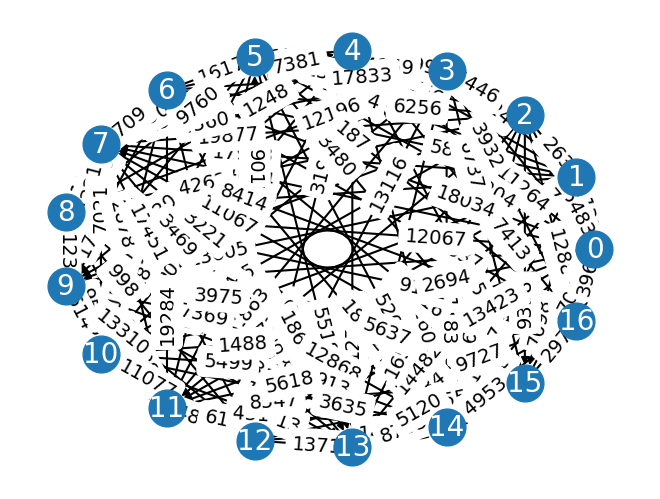

Instant Runoff (Truncated Linear Orders) winner is {6}
Minimax winner is {6}
[6] [6] Candace Avalos [6]


In [10]:
# Load the CSV file
file_path = '../../american/Portland, OR/Portland_D1_2024.csv'  # Replace with your CSV file path
election_data = pd.read_csv(file_path)
column_names_list = election_data.columns.tolist()
num_ranks=0
for item in column_names_list:
    if 'rank' in item:
        num_ranks+=1

# Function to process each voter's rankings, ignoring "overvote"
def process_rankings(row):
    seen_candidates = set()
    ranking = defaultdict(list)
    rank = 1
    
    for i in range(1, num_ranks+1):
        candidate = row[f'rank{i}']
        if candidate != 'overvote' and candidate != 'skipped' and candidate not in seen_candidates:
            ranking[rank].append(candidate)
            seen_candidates.add(candidate)
            rank += 1
    
    return {c: r for r, cs in ranking.items() for c in cs}

# Apply the function and count occurrences of each ranking
election_data['processed_rankings'] = election_data.apply(process_rankings, axis=1)
print(election_data)
ranking_counts = Counter(election_data['processed_rankings'].apply(tuple))

# Create candidate list and set "Write-in" index last
candidates = [c for c in set().union(*[r for r in ranking_counts])]


# Convert rankings to indices format
candidate_to_index = {candidate: index for index, candidate in enumerate(candidates)}

# Display the candidates and their indices for reference
candidates_with_indices = {index: candidate for candidate, index in candidate_to_index.items()}
print(candidates_with_indices)

# Function to convert rankings (in tuple format) to indices and create dictionaries as keys
def ranking_to_indices(ranking):
    ranking_dict = {}
    for rank, candidate in enumerate(ranking, start=1):
        ranking_dict[candidate_to_index.get(candidate, -1)] = rank
    return ranking_dict

# Creating rankings with indices, ignoring ballots with "overvote"
rankings = [ranking_to_indices(ranking) for ranking, count in ranking_counts.items()]
rcounts = [count for ranking, count in ranking_counts.items()]

# Create ProfileWithTies object
profile = ProfileWithTies(rankings, rcounts)
#profile.display()

# Treat unranked candidates as tied for last place below ranked candidates for the purposes of the margin graph
profile.use_extended_strict_preference()

# Display the margin graph
profile.display_margin_graph()

#borda_for_profile_with_ties.display(profile)
#IRV_winner=instant_runoff(profile,curr_cands=None, algorithm='basic')
instant_runoff_for_truncated_linear_orders.display(profile)
ws= instant_runoff_for_truncated_linear_orders(profile)
minimax.display(profile)
minimax_winner=minimax(profile,curr_cands=[0,1,2,3,4,5,6,7,8])
if len(copeland(profile))==1:
    copeland_winner=candidates_with_indices[copeland(profile)[0]]
plurality_winner=plurality(profile)
#bucklin_winner=bucklin(profile)
print(ws, minimax_winner,copeland_winner, plurality_winner)
